In [1]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import joblib

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def optimize_memory(df):
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type == 'int64':
            df[col] = df[col].astype('int32')
        elif col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'object':  # For string-based data
            df[col] = df[col].astype('category')
    return df

chunks = []
train_dataset = r"/content/GUIDE_Train.csv.zip"
# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(train_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks
df.head()


,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,1786,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,1492,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,2573,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,4528,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,3722,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [3]:
df.shape

(9516837, 45)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Id                  int32   
 1   OrgId               int32   
 2   IncidentId          int32   
 3   AlertId             int32   
 4   Timestamp           object  
 5   DetectorId          int32   
 6   AlertTitle          int32   
 7   Category            object  
 8   MitreTechniques     object  
 9   IncidentGrade       category
 10  ActionGrouped       object  
 11  ActionGranular      object  
 12  EntityType          object  
 13  EvidenceRole        category
 14  DeviceId            int32   
 15  Sha256              int32   
 16  IpAddress           int32   
 17  Url                 int32   
 18  AccountSid          int32   
 19  AccountUpn          int32   
 20  AccountObjectId     int32   
 21  AccountName         int32   
 22  DeviceName          int32   
 23  NetworkMessageId    int32   
 24

In [5]:
df.isnull().sum()

,0
Id,0
OrgId,0
IncidentId,0
AlertId,0
Timestamp,0
DetectorId,0
AlertTitle,0
Category,0
MitreTechniques,5468386
IncidentGrade,51340


In [6]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
duplicate_count

np.int64(22576)

In [7]:
# Target variable distribution
df['IncidentGrade'].value_counts()

,count
IncidentGrade,
BenignPositive,4110817
TruePositive,3322713
FalsePositive,2031967


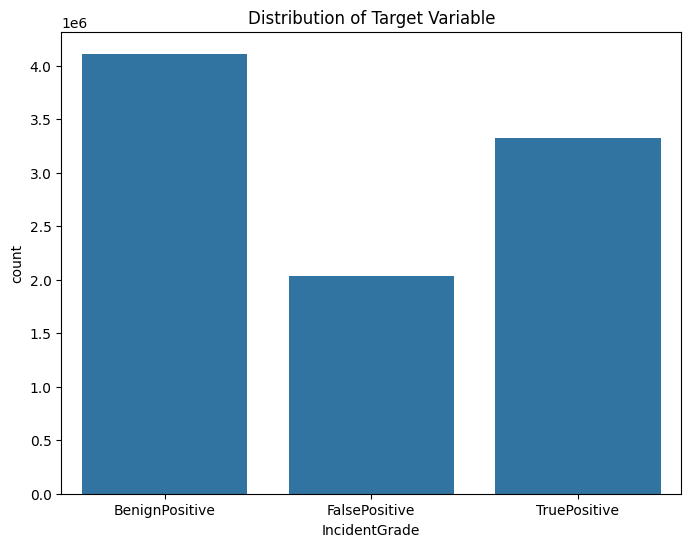

In [8]:
# plot Distribution of Target Variable
plt.figure(figsize=(8, 6))
sns.countplot(x=df['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().sum() / len(df) * 100

# List columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values are dropped")

# Drop these columns
df.drop(columns=columns_to_drop, axis=1, inplace=True)

Columns with more than 50% missing values are dropped


In [10]:
# Impute missing values for categorical columns
categorical_columns = df.select_dtypes(include=['object','category']).columns
for col in categorical_columns:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

Imputed categorical column 'IncidentGrade' with mode value: BenignPositive


In [11]:
# Impute missing values for numeric columns
numeric_columns = df.select_dtypes(include=['int32','float32']).columns
for col in numeric_columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

In [12]:
def outliers(df, iqr_multiplier=1.5):
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        if df[col].nunique() > 10:
            Q1 = numeric_features[col].quantile(0.25)
            Q3 = numeric_features[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Usage
df = outliers(df, iqr_multiplier=1.5)

In [13]:
# Feature Engineering
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Hour'] = df['Timestamp'].dt.hour


# Drop the 'Timestamp' column
df.drop(columns=['Timestamp'], inplace=True)

In [14]:
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256',
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName',
              'DeviceName', 'NetworkMessageId',  'RegistryKey', 'RegistryValueName',
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId',
              'FileName', 'FolderPath', 'ResourceIdName','OSFamily', 'OSVersion', 'City','CountryCode', 'State']

# Exclude ID columns from scaling
numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

# Scaling numerical features
scaler = MinMaxScaler()
df[numeric_features.columns] = scaler.fit_transform(numeric_features)

In [15]:
# categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string if necessary

In [16]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

In [17]:
# Save
path = r"C:\Users\WELCOME\Desktop\1_kavitha\Train_dataset.csv"
df.to_csv(path, index=False)
print("Data preprocessing complete and saved.")

Data preprocessing complete and saved.


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def optimize_memory(df_1):
    # Downcast numerical columns
    for col in df_1.columns:
        col_type = df_1[col].dtypes
        if col_type == 'int64':
            df_1[col] = df_1[col].astype('int32')
        elif col_type == 'float64':
            df_1[col] = df_1[col].astype('float32')
        elif col_type == 'object':  # For string-based data
            df_1[col] = df_1[col].astype('category')
    return df_1

chunks = []
test_dataset = r"/content/GUIDE_Test.csv.zip"
# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(test_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df_1 = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks

df_1.head()


,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,3390,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Private
1,3658,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,0,0,NaN,Suspicious,Suspicious,242,1445,10630,Public
2,1715,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Public
3,5148,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4,5019,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,Suspicious,5,66,NaN,NaN,NaN,242,1445,10630,Public



Shape of the dataset: (4147992, 46)
Column Names in the Dataset:
Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City', 'Usage'],
      dtype='object')

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147992 entries, 0 to 4147991
Data columns (total 46 columns):
 #   Column              Dtyp

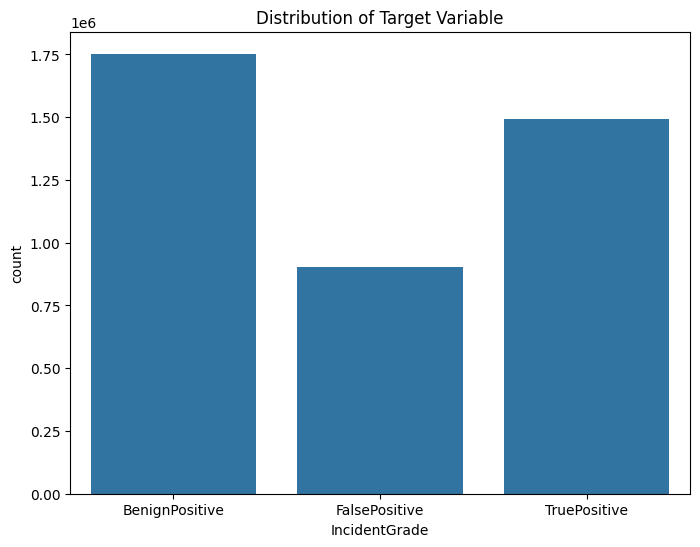

In [19]:

# Shape of the dataset
print("\nShape of the dataset:", df_1.shape)

# Column names
print("Column Names in the Dataset:")
print(df_1.columns)

print("\nDataset Information:")
print(df_1.info())

# Check for missing values
print("\nMissing values:")
print(df_1.isnull().sum())

# Check for duplicate rows
duplicate_count = df_1.duplicated().sum()
print("\nNumber of duplicate rows in the dataset:", duplicate_count)

# Target variable distribution
print("\nTarget variable distribution:")
print(df_1['IncidentGrade'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x=df_1['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

In [20]:
# Calculate the percentage of missing values for each column
missing_percentage = df_1.isnull().sum() / len(df_1) * 100

# List columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values are dropped:")
print(columns_to_drop)

# Drop these columns
df_1.drop(columns=columns_to_drop, axis=1, inplace=True)

# Impute missing values for numeric columns
numeric_columns = df_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).columns
for col in numeric_columns:
    if df_1[col].isnull().any():
        median_val = df_1[col].median()
        df_1[col] = df_1[col].fillna(median_val)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

# Impute missing values for categorical columns
categorical_columns = df_1.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df_1[col].isnull().any():
        mode_val = df_1[col].mode()[0]
        df_1[col] = df_1[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

# Handling Outliers
def outliers(df_1, iqr_multiplier=1.5):
    numeric_features = df_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        Q1 = numeric_features[col].quantile(0.25)
        Q3 = numeric_features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        df_1 = df_1[(df_1[col] >= lower_bound) & (df_1[col] <= upper_bound)]
    return df_1

# Usage
df_1 = outliers(df_1, iqr_multiplier=1.5)  # Adjusting the IQR multiplier if necessary

# Feature Engineering: Extracting datetime features
df_1['Timestamp'] = pd.to_datetime(df_1['Timestamp'], errors='coerce')
df_1['Year'] = df_1['Timestamp'].dt.year
df_1['Month'] = df_1['Timestamp'].dt.month
df_1['DayOfWeek'] = df_1['Timestamp'].dt.dayofweek
df_1['Hour'] = df_1['Timestamp'].dt.hour

# Drop the 'Timestamp' and 'Usage'column
df_1.drop(columns=['Timestamp','Usage'], inplace=True)

id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256',
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName',
              'DeviceName', 'NetworkMessageId',  'RegistryKey', 'RegistryValueName',
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId',
              'FileName', 'FolderPath', 'ResourceIdName','OSFamily','OSVersion', 'City','CountryCode', 'State']

# Exclude ID columns from scaling
numeric_features = df_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

# Scaling numerical features
scaler = MinMaxScaler()
df_1[numeric_features.columns] = scaler.fit_transform(numeric_features)

# categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']

for col in categorical_columns:
    if col in df_1.columns:
        df_1[col] = label_encoder.fit_transform(df_1[col].astype(str))  # Convert to string if necessary

# Remove duplicate rows
df_1.drop_duplicates(inplace=True)


Columns with more than 50% missing values are dropped:
Index(['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId',
       'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection',
       'SuspicionLevel', 'LastVerdict'],
      dtype='object')


In [22]:
# Save the process
path = r"C:\Users\WELCOME\Desktop\1_kavitha\Test_dataset.csv"
df_1.to_csv(path, index=False)
print("Data preprocessing complete and saved .")

Data preprocessing complete and saved .
